## **Sessa Empirical Estimator**

- Diaz, Kristian Lemuel W.
- Dulangon, Kent Anthony C.

### Library Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# For reproducibility
np.random.seed(1234)

## I. SEE using K-Means

In [21]:
# Load the dataset from the CSV file
tidy = pd.read_csv('./data/med_events.csv')

# Ensure DATE is parsed as a datetime
tidy['DATE'] = pd.to_datetime(tidy['DATE'])

print("Dataset preview:")
print(tidy.head())

Dataset preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION
0           1 2033-04-26       4     medA        50
1           1 2033-07-04       4     medB        30
2           1 2033-08-03       4     medB        30
3           1 2033-08-17       4     medB        30
4           1 2033-10-13       4     medB        30


In [22]:
def see(med_code):
    # Filter data for the specified medication category
    data = tidy[tidy['CATEGORY'] == med_code].copy()
    Drug_see_p0 = data.copy()  # This will be merged later
    Drug_see_p1 = data.copy()
    
    patient_counts_original = data['PATIENT_ID'].value_counts()

    plt.figure(figsize=(16, 6))
    plt.bar(patient_counts_original.index.astype(str), 
            patient_counts_original.values, 
            color='skyblue')
    plt.title('Patient Prescription Frequency (Original)')
    plt.xlabel('Patient ID')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Sort by patient and date; compute the previous prescription date per patient
    Drug_see_p1.sort_values(['PATIENT_ID', 'DATE'], inplace=True)
    Drug_see_p1['prev_DATE'] = Drug_see_p1.groupby('PATIENT_ID')['DATE'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_DATE'])
    
    # Randomly sample one row per patient using a fixed random seed
    Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID').apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)
    Drug_see_p1 = Drug_see_p1[['PATIENT_ID', 'DATE', 'prev_DATE']]
    
    # Compute the event interval in days between prescriptions
    Drug_see_p1['event_interval'] = (Drug_see_p1['DATE'] - Drug_see_p1['prev_DATE']).dt.days.astype(float)
    
    # --- ECDF Calculation ---
    sorted_intervals = np.sort(Drug_see_p1['event_interval'])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})
    
    # Retain the lower 80% of the ECDF
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot the ECDFs
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axes[0].set_title('80% ECDF')
    axes[0].set_xlabel('Event Interval (days)')
    axes[0].set_ylabel('ECDF')
    axes[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axes[1].set_title('100% ECDF')
    axes[1].set_xlabel('Event Interval (days)')
    axes[1].set_ylabel('ECDF')
    plt.tight_layout()
    plt.show()
    
    # Plot frequency from the sampled data (one row per patient)
    patient_counts_sampled = Drug_see_p1['PATIENT_ID'].value_counts()
    plt.figure(figsize=(16, 6))
    patient_counts_sampled.plot(kind='bar')
    plt.title('Patient Prescription Frequency (Sampled)')
    plt.xlabel('Patient ID')
    plt.ylabel('Frequency')
    plt.show()
    
    # --- Density Estimation on Log(Event Interval) ---
    valid_intervals = Drug_see_p1[(Drug_see_p1['event_interval'] <= ni) & (Drug_see_p1['event_interval'] > 0)]
    if valid_intervals.empty:
        print("No valid event intervals for density estimation.")
        return Drug_see_p0
    
    log_intervals = np.log(valid_intervals['event_interval'])
    log_intervals = log_intervals.replace(-np.inf, np.nan).dropna()
    
    print("Log intervals stats: min = {:.3f}, max = {:.3f}, mean = {:.3f}".format(
          log_intervals.min(), log_intervals.max(), log_intervals.mean()))
    
    try:
        kde = gaussian_kde(log_intervals)
    except Exception as e:
        print("Error during KDE computation:", e)
        return Drug_see_p0

    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    plt.figure(figsize=(16, 6))
    plt.plot(x1, y1)
    plt.title('Density of Log(Event Interval)')
    plt.xlabel('log(Event Interval)')
    plt.ylabel('Density')
    plt.show()
    
    # --- Silhouette Analysis to Determine Optimal Number of Clusters ---
    density_df = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    density_scaled = scaler.fit_transform(density_df)
    
    best_k = 2
    best_score = -1
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(density_scaled)
        score = silhouette_score(density_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    print("Optimal number of clusters (silhouette):", best_k)
    
    # --- K-means Clustering on the ECDF x values ---
    kmeans_final = KMeans(n_clusters=best_k, random_state=1234)
    clusters = kmeans_final.fit_predict(dfper[['x']])
    dfper['cluster'] = clusters
    
    # Compute min, max, and median (after log transform) for each cluster, then exponentiate
    dfper['log_x'] = np.log(dfper['x'])
    boundaries = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    boundaries['Minimum'] = np.exp(boundaries['min'])
    boundaries['Maximum'] = np.exp(boundaries['max'])
    boundaries['Median'] = np.exp(boundaries['median'])
    boundaries = boundaries[['cluster', 'Minimum', 'Maximum', 'Median']]
    
    # --- Cross Join and Cluster Assignment ---
    Drug_see_p1['key'] = 1
    boundaries['key'] = 1
    cross = pd.merge(Drug_see_p1, boundaries, on='key').drop('key', axis=1)
    
    cross['Final_cluster'] = cross.apply(
        lambda row: row['cluster'] if (row['event_interval'] >= row['Minimum'] and row['event_interval'] <= row['Maximum'])
        else np.nan,
        axis=1
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['PATIENT_ID', 'Median', 'Final_cluster']]
    results.rename(columns={'Final_cluster': 'cluster'}, inplace=True)
    
    # Determine the most frequent cluster and its median (fallback)
    most_freq_cluster = results['cluster'].value_counts().idxmax()
    most_freq_median = results.loc[results['cluster'] == most_freq_cluster, 'Median'].iloc[0]
    
    # Merge cluster assignments back into the sampled data
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='PATIENT_ID', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(most_freq_median)
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event_interval'] - Drug_see_p1['Median'], 1)
    
    # Merge back with the original filtered dataset for final output
    final_result = pd.merge(Drug_see_p0, Drug_see_p1[['PATIENT_ID', 'Median', 'cluster']], on='PATIENT_ID', how='left')
    final_result['Median'] = final_result['Median'].fillna(most_freq_median)
    final_result['cluster'] = final_result['cluster'].fillna(0)
    
    return final_result


def see_assumption(df):
    # Sort by patient and date; compute previous prescription date
    df_sorted = df.sort_values(['PATIENT_ID', 'DATE']).copy()
    df_sorted['prev_DATE'] = df_sorted.groupby('PATIENT_ID')['DATE'].shift(1)
    
    # Create a prescription sequence number for each patient
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_filtered = df_filtered[['PATIENT_ID', 'DATE', 'prev_DATE', 'p_number']]
    
    # Compute Duration (in days) between prescriptions
    df_filtered['Duration'] = (df_filtered['DATE'] - df_filtered['prev_DATE']).dt.days
    
    plt.figure(figsize=(16, 6))
    sns.boxplot(x=df_filtered['p_number'].astype(str), y=df_filtered['Duration'])
    plt.title('Duration by Prescription Number')
    
    medians_of_medians = df_filtered.groupby('PATIENT_ID')['Duration'].median().median()
    plt.axhline(y=medians_of_medians, linestyle='--', color='red', label=f'Median = {medians_of_medians:.1f} days')
    plt.legend()
    plt.show()
    
    return df_filtered


def generate_insights(result, med_code):
    cluster_counts = result['cluster'].value_counts().sort_index()
    overall_median = result['Median'].median()
    print(f"Insights for {med_code}:")
    print("Cluster distribution (number of patients assigned to each cluster):")
    print(cluster_counts)
    print(f"\nOverall median event interval used for clustering: {overall_median:.1f} days\n")

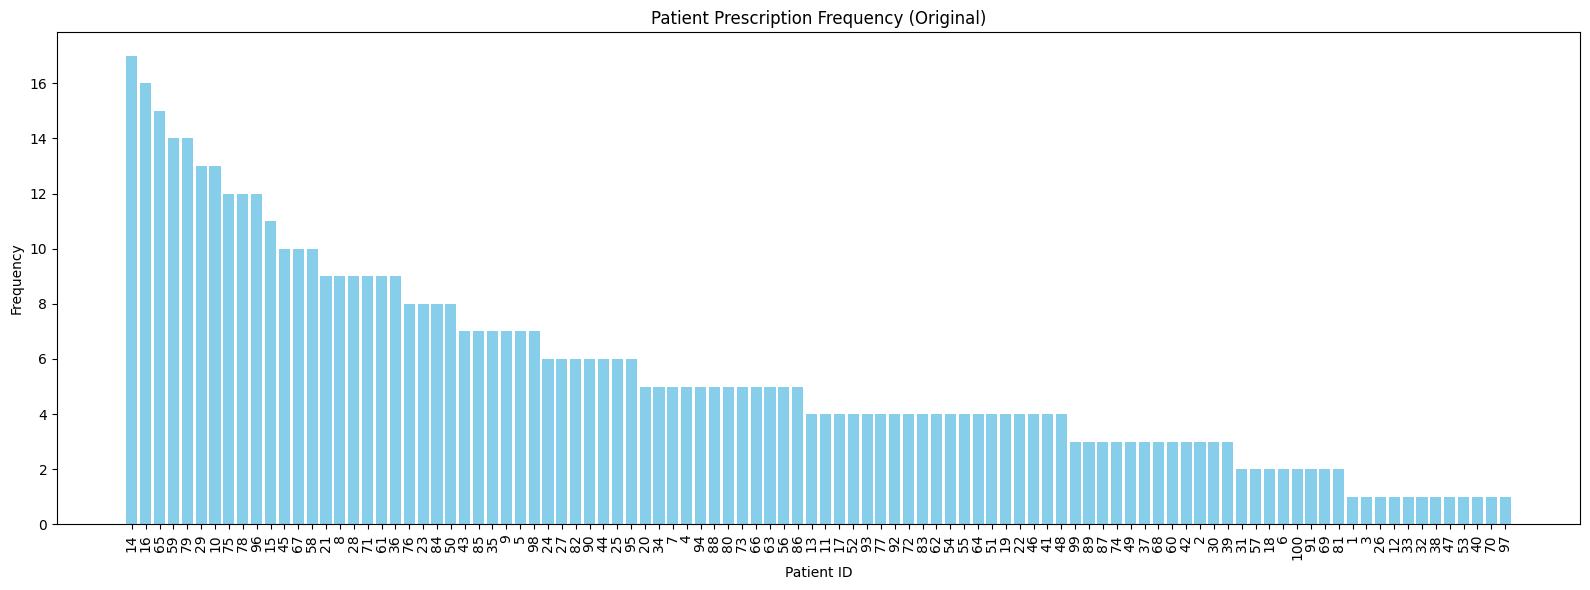

C:\Users\dkent\AppData\Local\Temp\ipykernel_15752\2029074896.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID').apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)


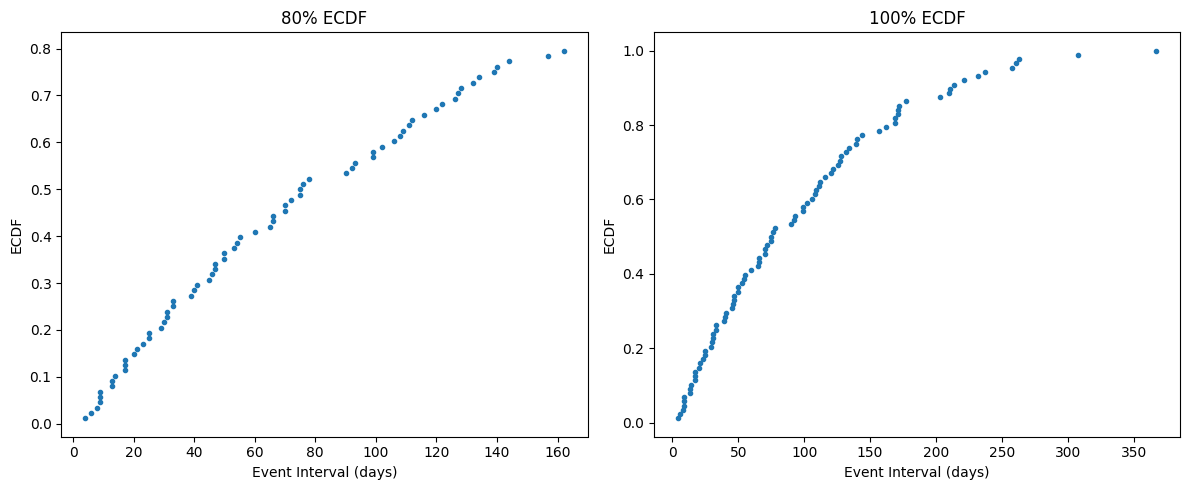

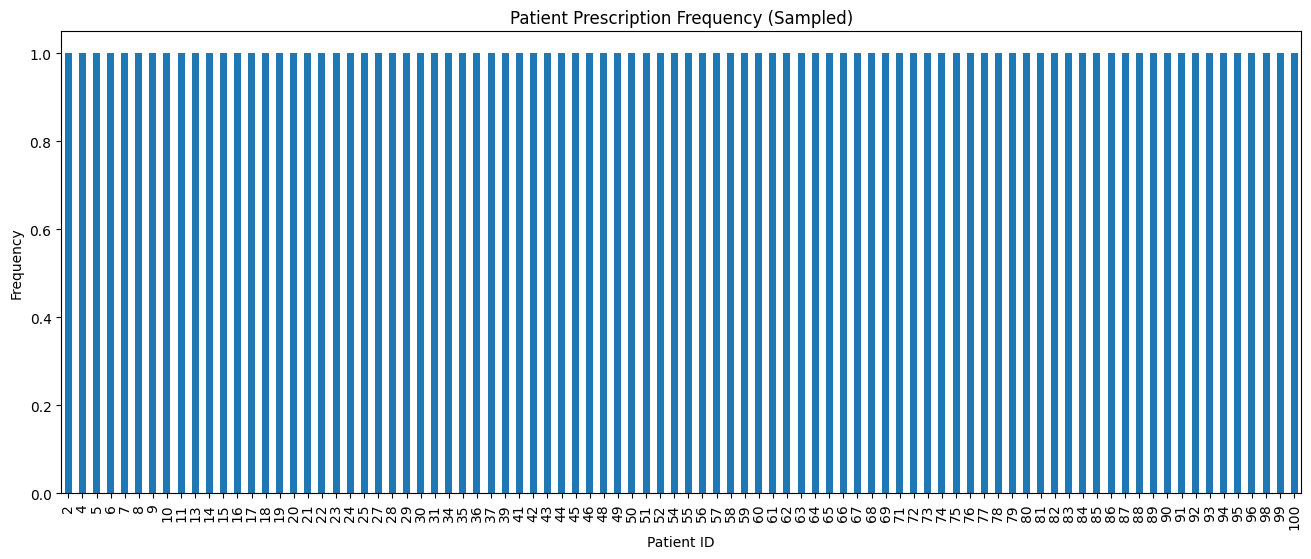

Log intervals stats: min = 1.386, max = 5.088, mean = 3.883


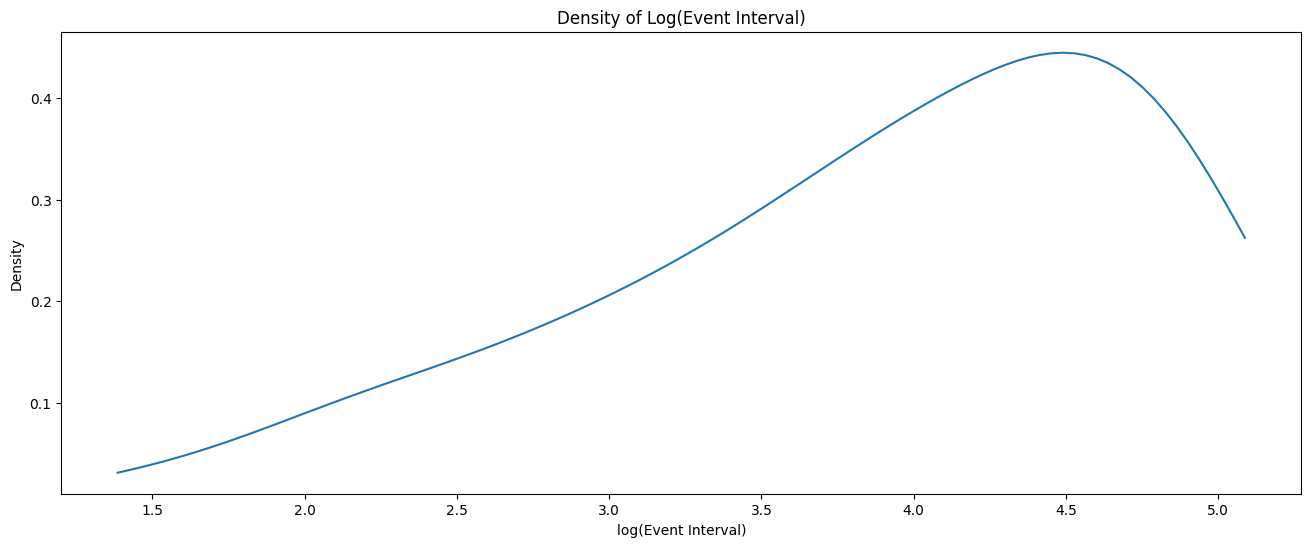

Optimal number of clusters (silhouette): 2


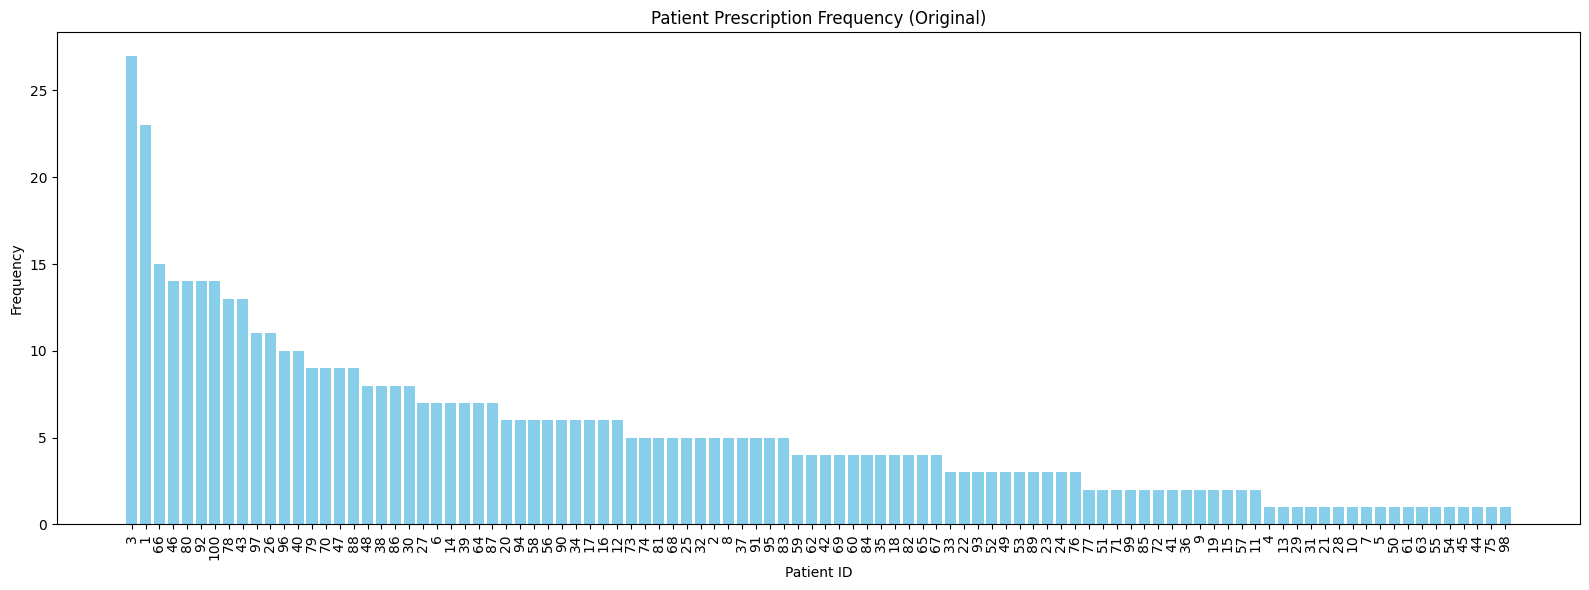

C:\Users\dkent\AppData\Local\Temp\ipykernel_15752\2029074896.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID').apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)


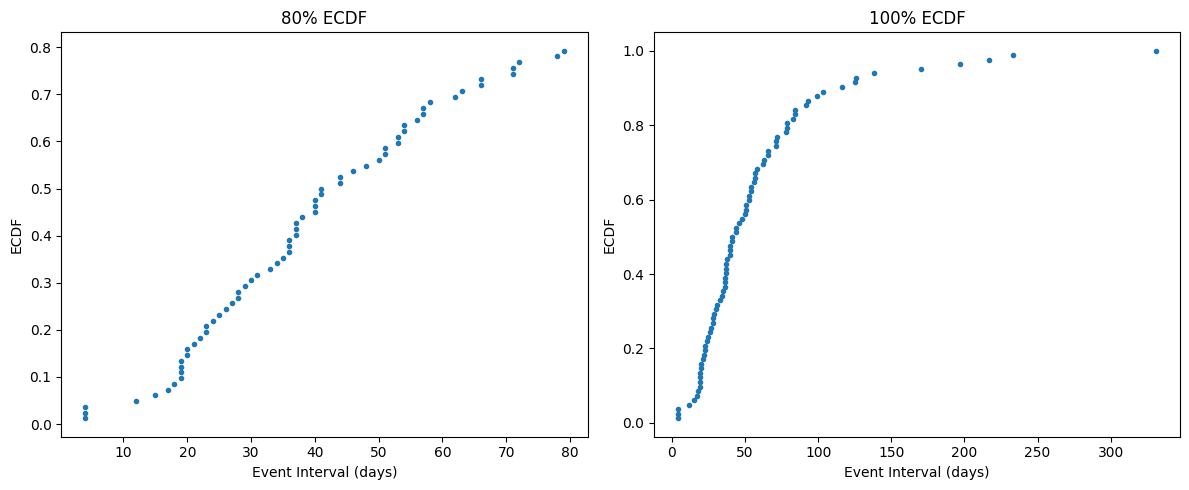

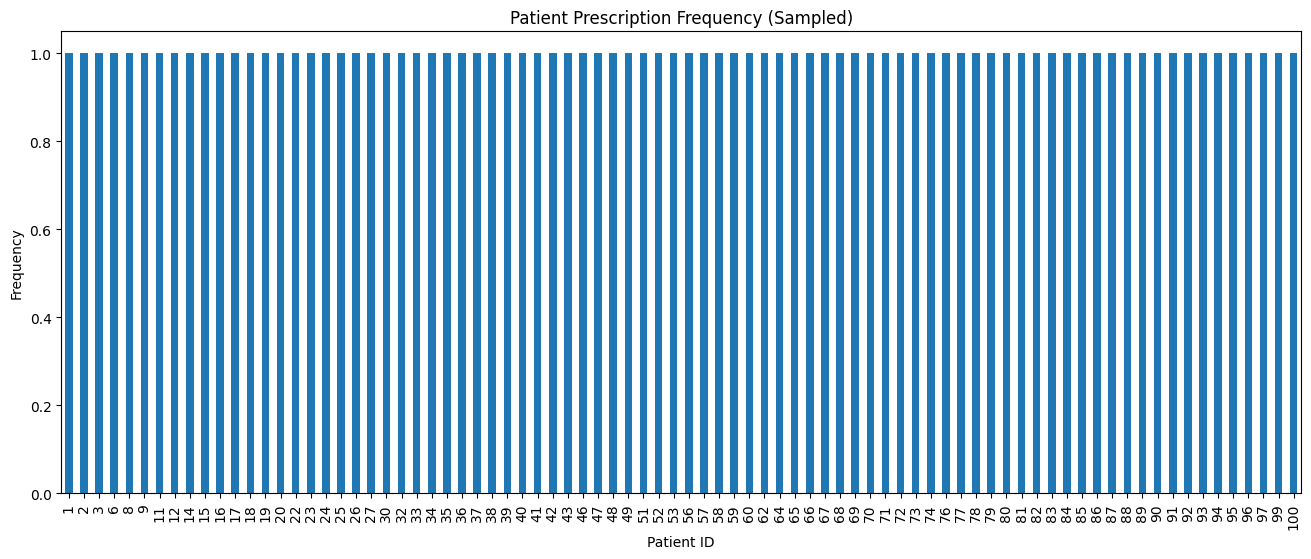

Log intervals stats: min = 1.386, max = 4.369, mean = 3.501


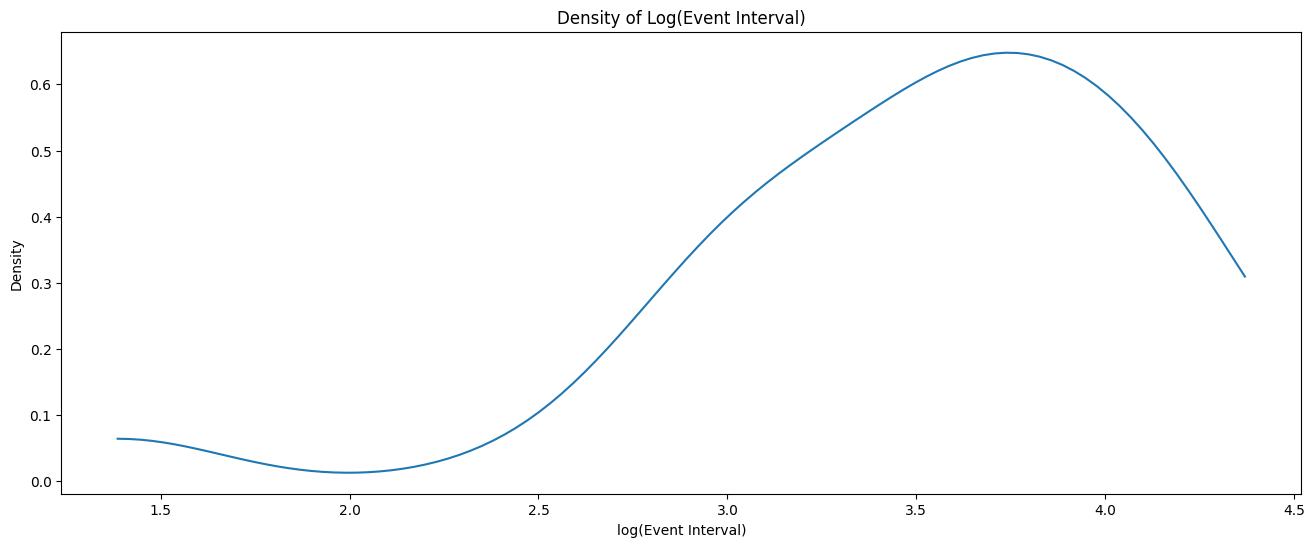

Optimal number of clusters (silhouette): 2
medA clustering result preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION  Median  cluster
0           1 2033-04-26       4     medA        50    47.0      0.0
1           2 2036-01-20       4     medA        50    47.0      0.0
2           2 2036-03-10       4     medA        50    47.0      0.0
3           2 2036-08-01       4     medA        50    47.0      0.0
4           3 2042-04-13       4     medA        50    47.0      0.0

medB clustering result preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION  Median  cluster
0           1 2033-07-04       4     medB        30    40.0      0.0
1           1 2033-08-03       4     medB        30    40.0      0.0
2           1 2033-08-17       4     medB        30    40.0      0.0
3           1 2033-10-13       4     medB        30    40.0      0.0
4           1 2033-10-16       4     medB        30    40.0      0.0


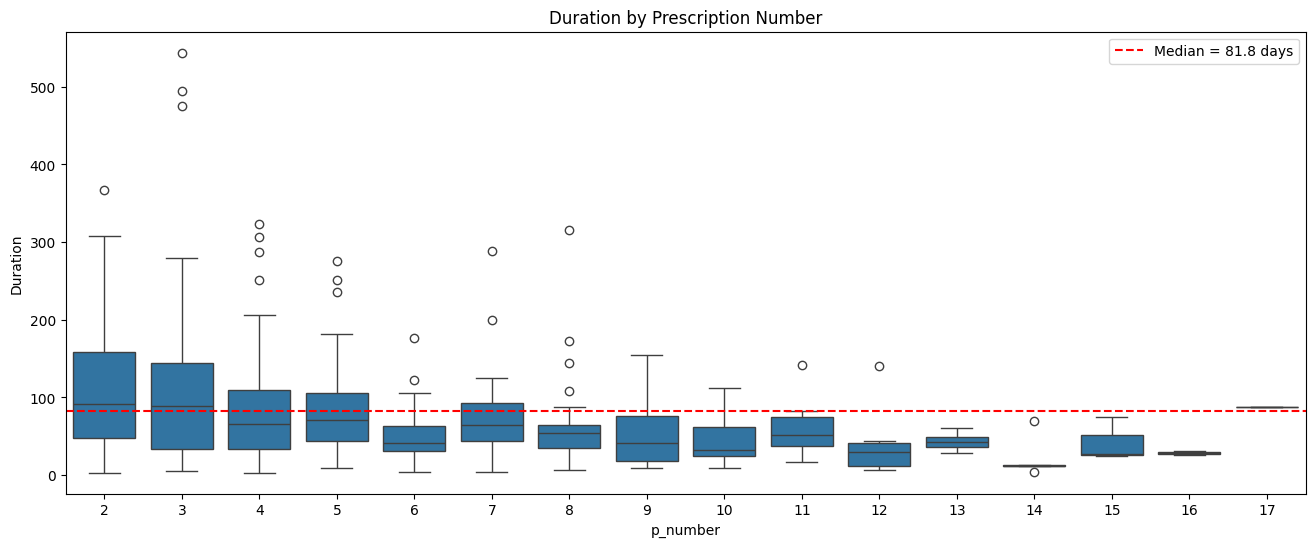

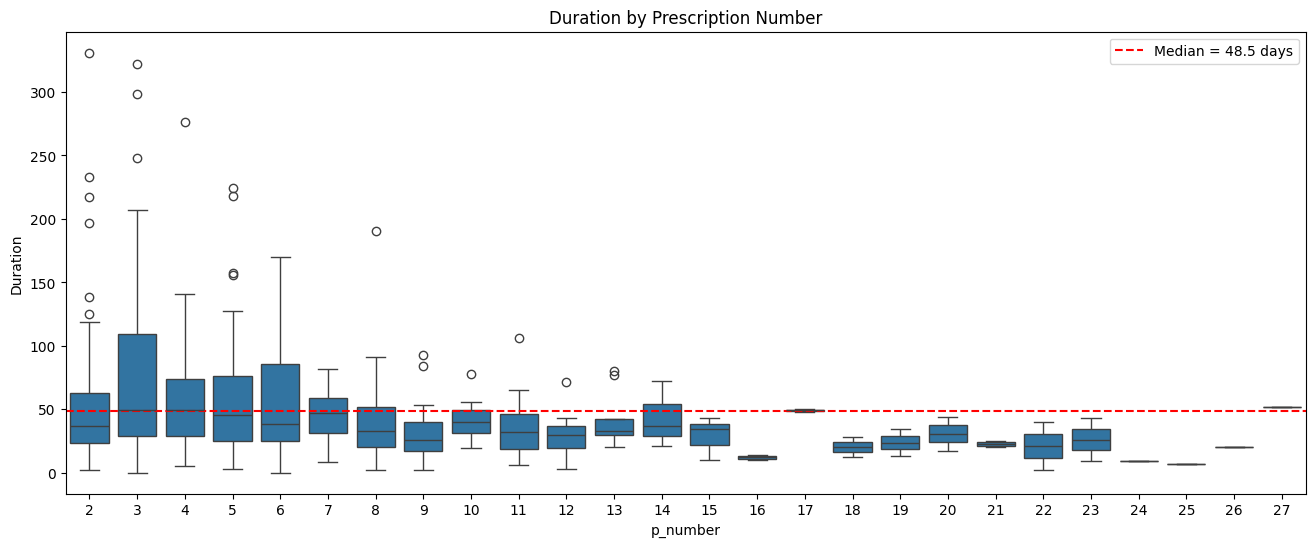

Insights for medA:
Cluster distribution (number of patients assigned to each cluster):
cluster
0.0    435
1.0    114
Name: count, dtype: int64

Overall median event interval used for clustering: 47.0 days

Insights for medB:
Cluster distribution (number of patients assigned to each cluster):
cluster
0.0    501
1.0     30
Name: count, dtype: int64

Overall median event interval used for clustering: 40.0 days



In [23]:
# Run the Sessa Empirical Estimator for medA and medB
medA_result = see("medA")
medB_result = see("medB")

# Display a preview of the results
print("medA clustering result preview:")
print(medA_result.head())

print("\nmedB clustering result preview:")
print(medB_result.head())

# Generate assumption visualizations for medA and medB
see_assumption(medA_result)
see_assumption(medB_result)

# Generate insights for both medication categories
generate_insights(medA_result, "medA")
generate_insights(medB_result, "medB")


## II. SEE using Gaussian Mixture Models (GMM)

In [24]:
# Read your dataset (med_events.csv)
tidy = pd.read_csv("./data/med_events.csv")
tidy['DATE'] = pd.to_datetime(tidy['DATE'])
print("Dataset preview:")
print(tidy.head())

Dataset preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION
0           1 2033-04-26       4     medA        50
1           1 2033-07-04       4     medB        30
2           1 2033-08-03       4     medB        30
3           1 2033-08-17       4     medB        30
4           1 2033-10-13       4     medB        30


In [25]:
def see_gmm(med_code):
    # Filter data for the specified medication/category
    data = tidy[tidy['CATEGORY'] == med_code].copy()
    Drug_see_p0 = data.copy()  # For final merging
    Drug_see_p1 = data.copy()
    
    # Plot frequency of patient counts from the original data (actual prescription counts)
    patient_counts_original = data['PATIENT_ID'].value_counts().sort_index()

    plt.figure(figsize=(12, 4))
    plt.bar(patient_counts_original.index.astype(str), patient_counts_original.values, color='skyblue')
    plt.title('Patient Prescription Frequency (Original)')
    plt.xlabel('Patient ID')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
        
    # Sort by patient and date; compute the previous prescription date per patient
    Drug_see_p1.sort_values(['PATIENT_ID', 'DATE'], inplace=True)
    Drug_see_p1['prev_DATE'] = Drug_see_p1.groupby('PATIENT_ID')['DATE'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_DATE'])
    
    # For each patient, randomly sample one row
    Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID', group_keys=False).apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)
    Drug_see_p1 = Drug_see_p1[['PATIENT_ID', 'DATE', 'prev_DATE']]
    
    # Compute event interval (in days)
    Drug_see_p1['event_interval'] = (Drug_see_p1['DATE'] - Drug_see_p1['prev_DATE']).dt.days.astype(float)
    
    # --- ECDF Calculation ---
    sorted_intervals = np.sort(Drug_see_p1['event_interval'])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})
    
    # Retain the lower 80% of the ECDF
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot ECDFs
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axes[0].set_title('80% ECDF')
    axes[0].set_xlabel('Event Interval (days)')
    axes[0].set_ylabel('ECDF')
    axes[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axes[1].set_title('100% ECDF')
    axes[1].set_xlabel('Event Interval (days)')
    axes[1].set_ylabel('ECDF')
    plt.tight_layout()
    plt.show()
    
    patient_counts_sampled = Drug_see_p1['PATIENT_ID'].value_counts().sort_index()

    plt.figure(figsize=(20, 6))
    plt.bar(patient_counts_sampled.index.astype(str), patient_counts_sampled.values, color='skyblue')
    plt.title('Patient Prescription Frequency (Sampled)')
    plt.xlabel('Patient ID')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # --- Density Estimation on Log(Event Interval) ---
    valid_intervals = Drug_see_p1[(Drug_see_p1['event_interval'] <= ni) & (Drug_see_p1['event_interval'] > 0)]
    if valid_intervals.empty:
        print("No valid event intervals for density estimation.")
        return Drug_see_p0
    
    log_intervals = np.log(valid_intervals['event_interval'])
    log_intervals = log_intervals.replace(-np.inf, np.nan).dropna()
    
    print("Log intervals stats: min = {:.3f}, max = {:.3f}, mean = {:.3f}".format(
          log_intervals.min(), log_intervals.max(), log_intervals.mean()))
    
    try:
        kde = gaussian_kde(log_intervals)
    except Exception as e:
        print("Error during KDE computation:", e)
        return Drug_see_p0

    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    plt.figure(figsize=(8,4))
    plt.plot(x1, y1)
    plt.title('Density of Log(Event Interval)')
    plt.xlabel('log(Event Interval)')
    plt.ylabel('Density')
    plt.show()
    
    # --- Gaussian Mixture Model (GMM) Clustering ---
    bic_scores = []
    models = []
    n_components_range = range(2, 11)
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=1234)
        gmm.fit(dfper[['x']])
        bic = gmm.bic(dfper[['x']])
        bic_scores.append(bic)
        models.append(gmm)
    best_index = np.argmin(bic_scores)
    best_components = n_components_range[best_index]
    best_gmm = models[best_index]
    print("Optimal number of GMM components (by BIC):", best_components)
    
    dfper['cluster'] = best_gmm.predict(dfper[['x']])
    
    # Compute cluster boundaries
    dfper['log_x'] = np.log(dfper['x'])
    boundaries = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    boundaries['Minimum'] = np.exp(boundaries['min'])
    boundaries['Maximum'] = np.exp(boundaries['max'])
    boundaries['Median'] = np.exp(boundaries['median'])
    boundaries = boundaries[['cluster', 'Minimum', 'Maximum', 'Median']]
    
    # --- Cross Join and Cluster Assignment ---
    Drug_see_p1['key'] = 1
    boundaries['key'] = 1
    cross = pd.merge(Drug_see_p1, boundaries, on='key').drop('key', axis=1)
    
    cross['Final_cluster'] = cross.apply(
        lambda row: row['cluster'] if (row['event_interval'] >= row['Minimum'] and row['event_interval'] <= row['Maximum'])
        else np.nan,
        axis=1
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['PATIENT_ID', 'Median', 'Final_cluster']]
    results.rename(columns={'Final_cluster': 'cluster'}, inplace=True)
    
    # Fallback: Use the median from the most frequent cluster if needed
    most_freq_cluster = results['cluster'].value_counts().idxmax()
    most_freq_median = results.loc[results['cluster'] == most_freq_cluster, 'Median'].iloc[0]
    
    # Merge the cluster assignments back into the sampled data
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='PATIENT_ID', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(most_freq_median)
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event_interval'] - Drug_see_p1['Median'], 1)
    
    final_result = pd.merge(Drug_see_p0, Drug_see_p1[['PATIENT_ID', 'Median', 'cluster']], on='PATIENT_ID', how='left')
    final_result['Median'] = final_result['Median'].fillna(most_freq_median)
    final_result['cluster'] = final_result['cluster'].fillna(0)
    
    return final_result


def see_assumption(df):
    # Plot the duration between prescriptions per patient
    df_sorted = df.sort_values(['PATIENT_ID', 'DATE']).copy()
    df_sorted['prev_DATE'] = df_sorted.groupby('PATIENT_ID')['DATE'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_filtered = df_filtered[['PATIENT_ID', 'DATE', 'prev_DATE', 'p_number']]
    df_filtered['Duration'] = (df_filtered['DATE'] - df_filtered['prev_DATE']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_filtered['p_number'].astype(str), y=df_filtered['Duration'])
    plt.title('Duration by Prescription Number')
    
    medians_of_medians = df_filtered.groupby('PATIENT_ID')['Duration'].median().median()
    plt.axhline(y=medians_of_medians, linestyle='--', color='red', label=f'Median = {medians_of_medians:.1f} days')
    plt.legend()
    plt.show()


def generate_gmm_insights(result, med_code):
    cluster_counts = result['cluster'].value_counts().sort_index()
    overall_median = result['Median'].median()
    print(f"Insights for {med_code} using GMM:")
    print("Cluster distribution (number of patients assigned to each cluster):")
    print(cluster_counts)
    # Average median event interval per cluster
    avg_intervals = result.groupby('cluster')['Median'].mean()
    print("\nAverage median event interval per cluster:")
    print(avg_intervals)
    print(f"\nOverall median event interval used for clustering: {overall_median:.1f} days\n")


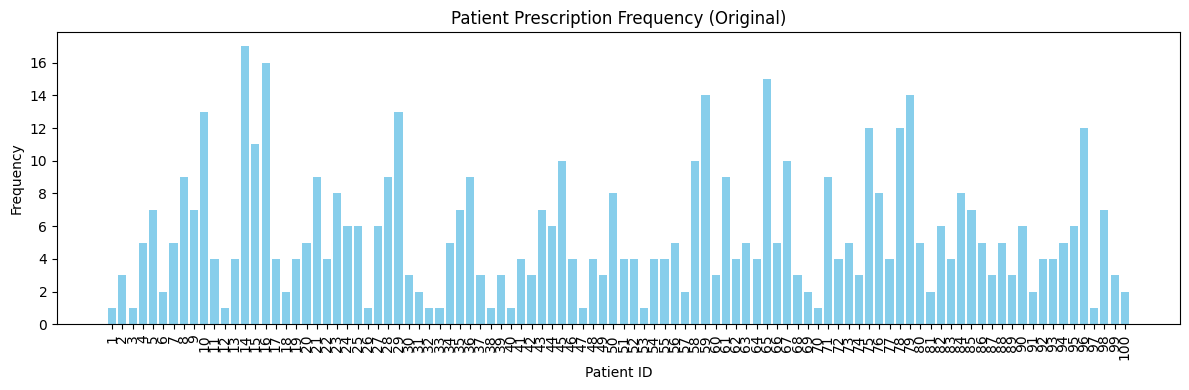

C:\Users\dkent\AppData\Local\Temp\ipykernel_15752\162389026.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID', group_keys=False).apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)


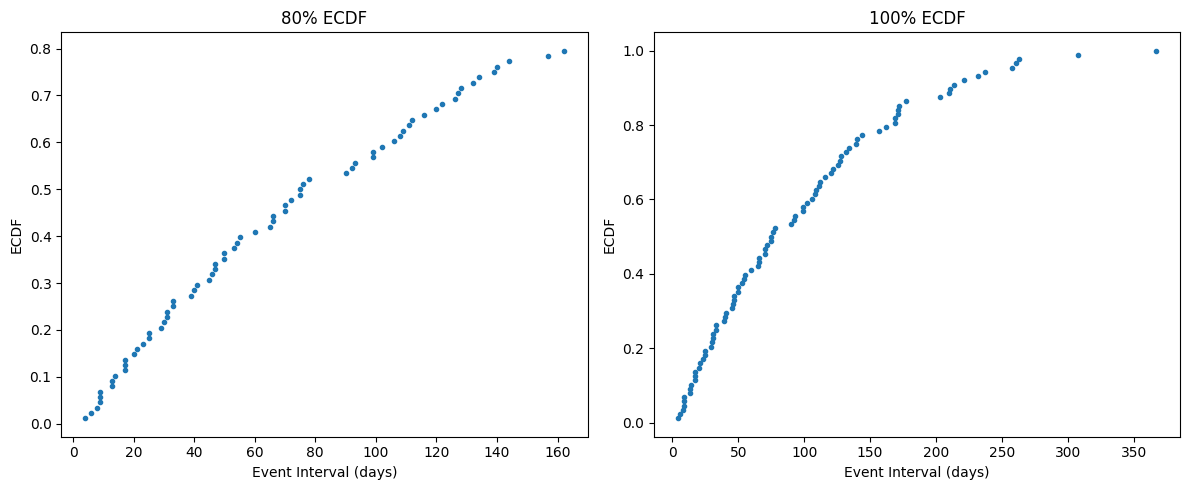

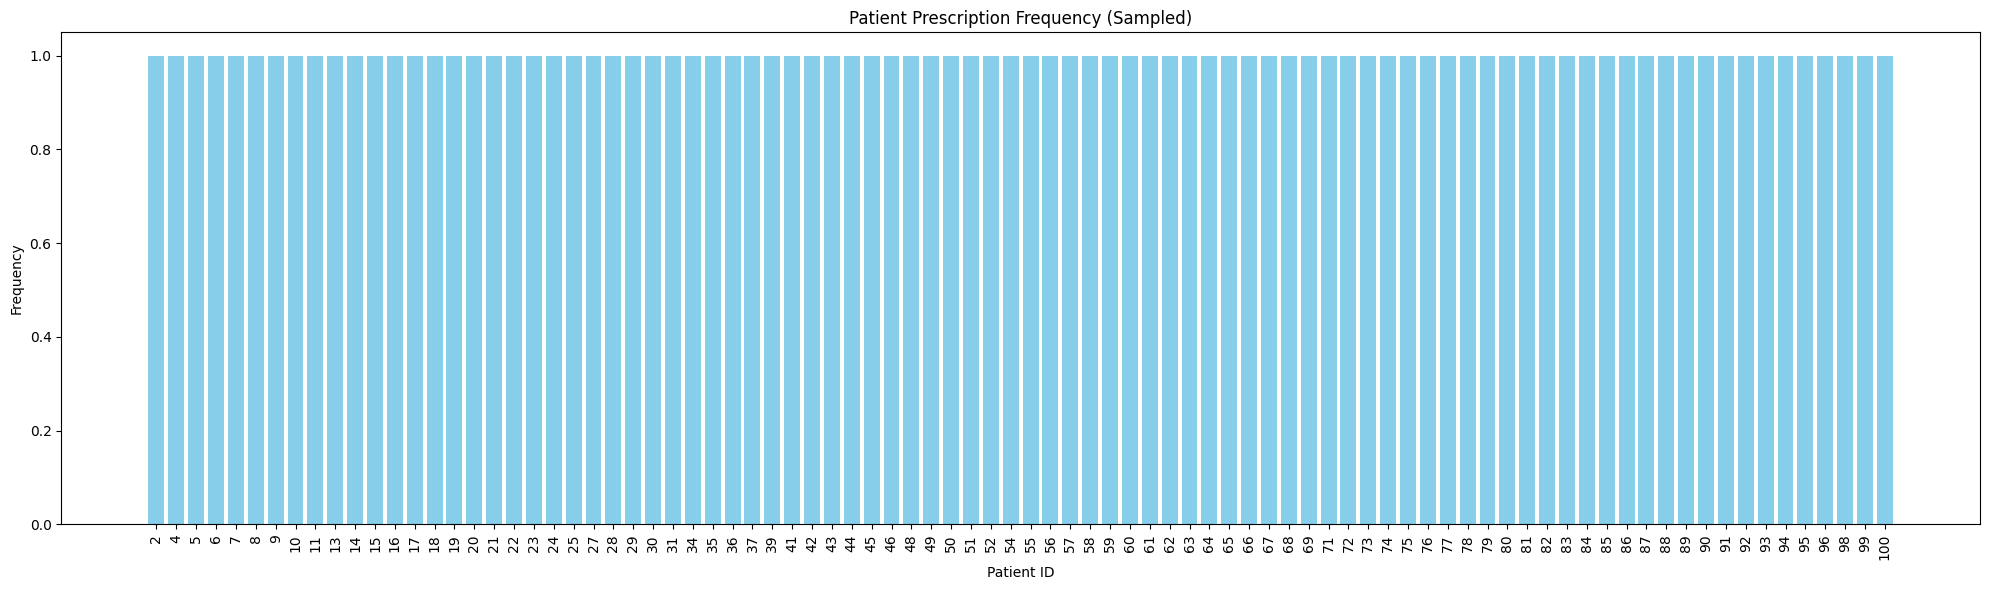

Log intervals stats: min = 1.386, max = 5.088, mean = 3.883


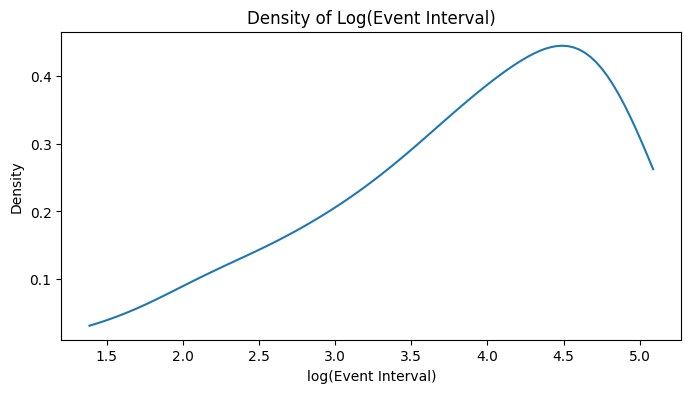

Optimal number of GMM components (by BIC): 2


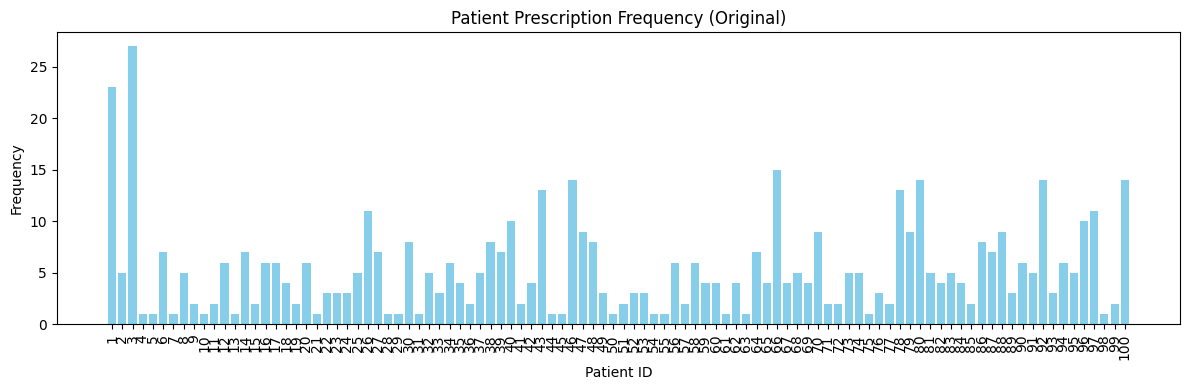

C:\Users\dkent\AppData\Local\Temp\ipykernel_15752\162389026.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('PATIENT_ID', group_keys=False).apply(lambda x: x.sample(n=1, random_state=1234)).reset_index(drop=True)


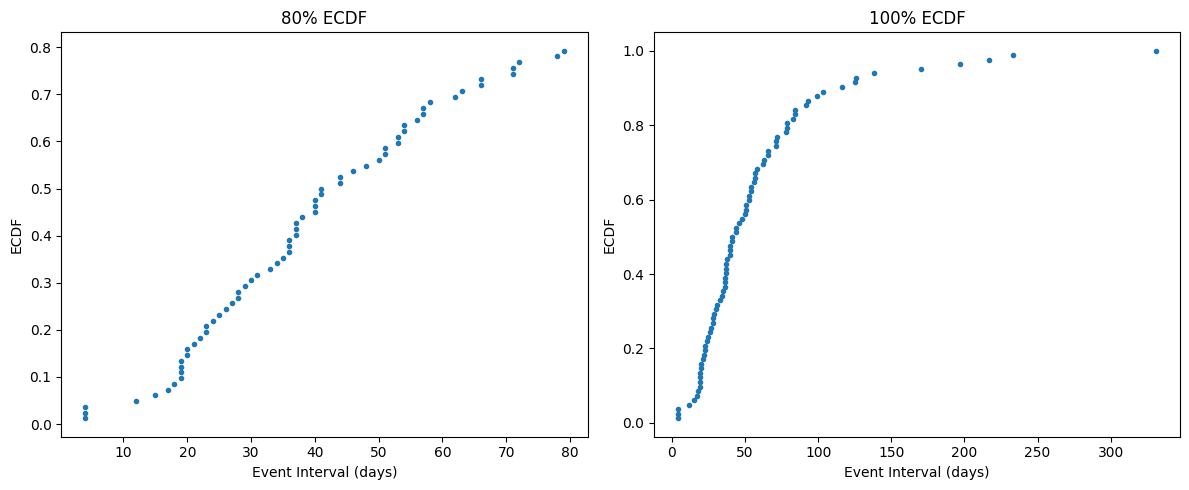

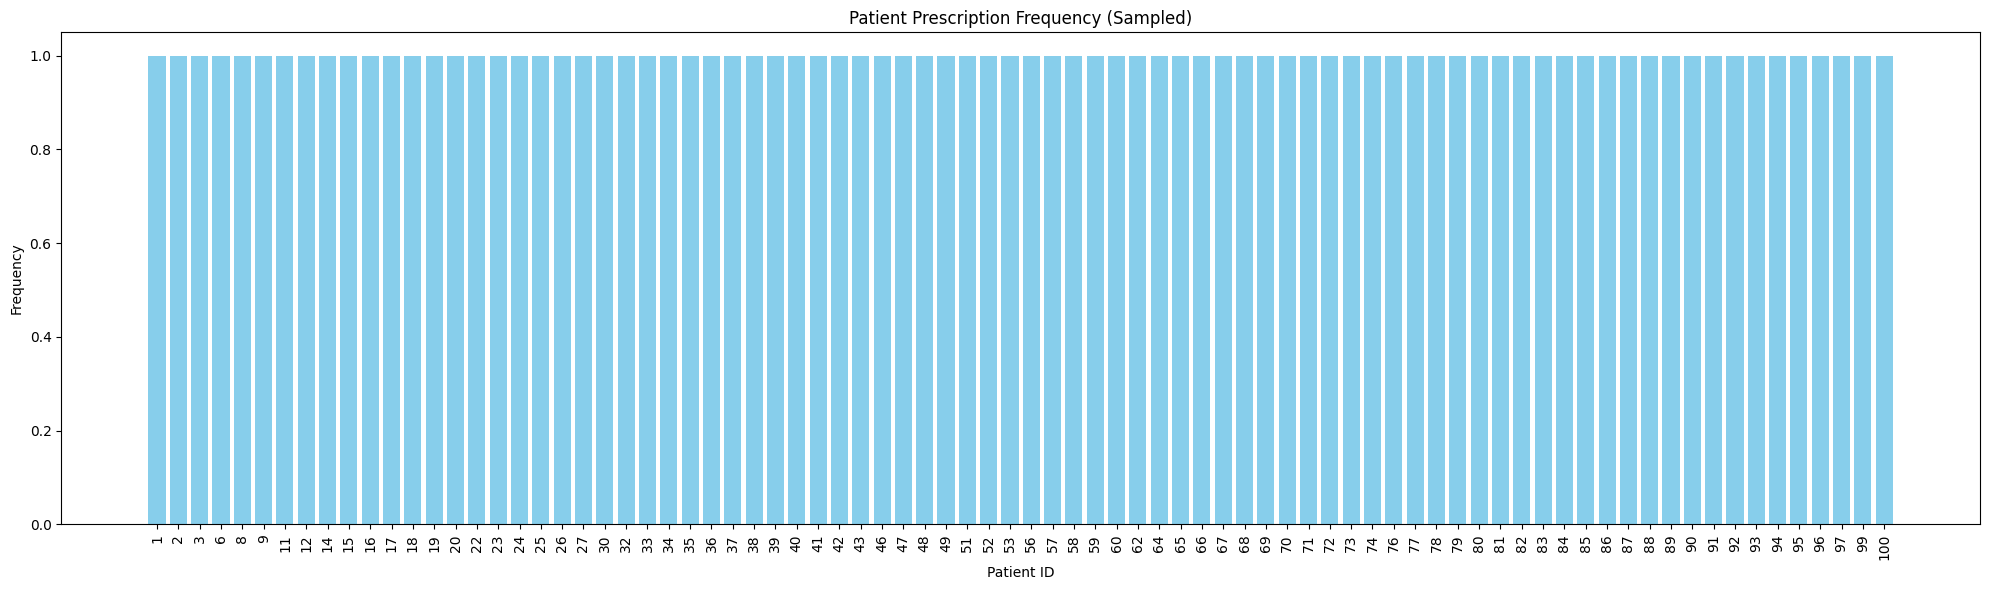

Log intervals stats: min = 1.386, max = 4.369, mean = 3.501


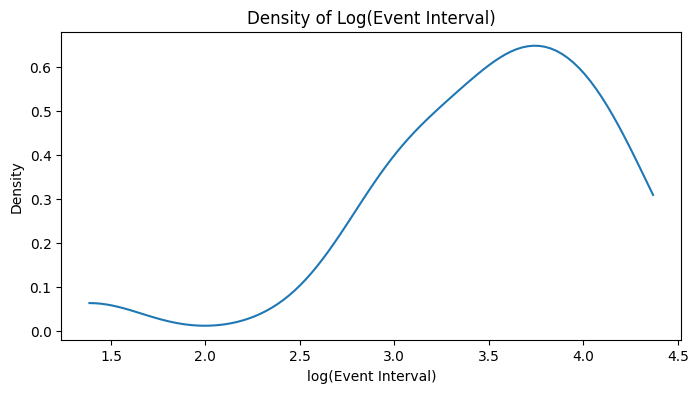

Optimal number of GMM components (by BIC): 4
medA clustering result (GMM) preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION      Median  cluster
0           1 2033-04-26       4     medA        50  139.499104      0.0
1           2 2036-01-20       4     medA        50   33.000000      0.0
2           2 2036-03-10       4     medA        50   33.000000      0.0
3           2 2036-08-01       4     medA        50   33.000000      0.0
4           3 2042-04-13       4     medA        50  139.499104      0.0

medB clustering result (GMM) preview:
   PATIENT_ID       DATE  PERDAY CATEGORY  DURATION     Median  cluster
0           1 2033-07-04       4     medB        30  34.496377      0.0
1           1 2033-08-03       4     medB        30  34.496377      0.0
2           1 2033-08-17       4     medB        30  34.496377      0.0
3           1 2033-10-13       4     medB        30  34.496377      0.0
4           1 2033-10-16       4     medB        30  34.496377      0.0


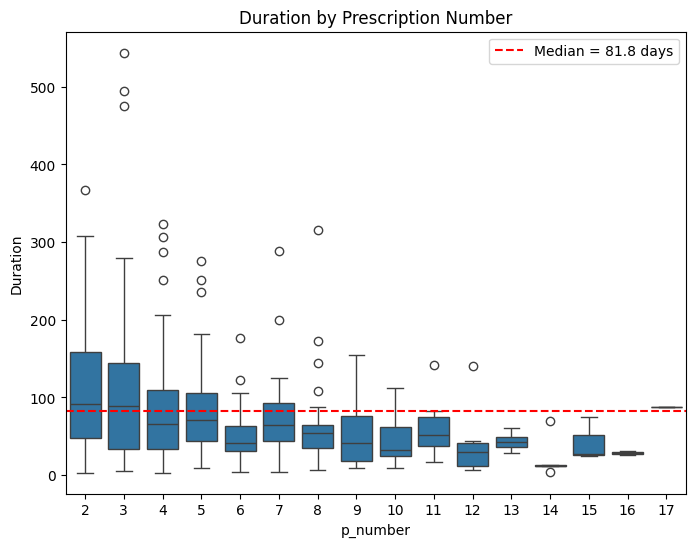

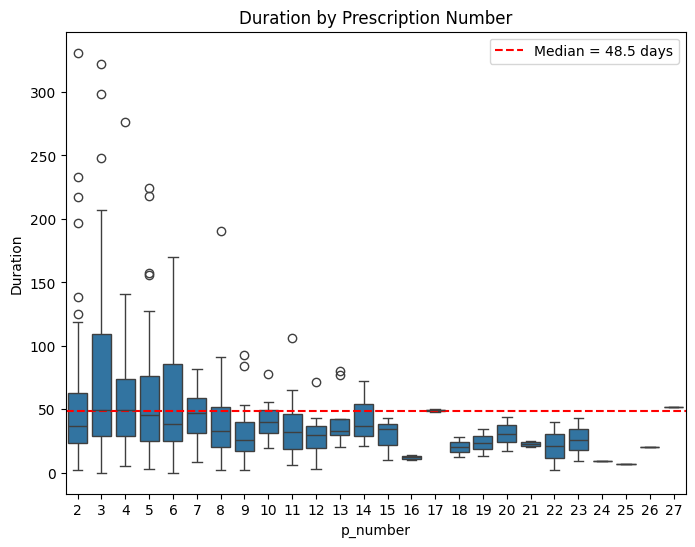

Insights for medA using GMM:
Cluster distribution (number of patients assigned to each cluster):
cluster
0.0    344
1.0    205
Name: count, dtype: int64

Average median event interval per cluster:
cluster
0.0     43.835665
1.0    139.499104
Name: Median, dtype: float64

Overall median event interval used for clustering: 33.0 days

Insights for medB using GMM:
Cluster distribution (number of patients assigned to each cluster):
cluster
0.0    396
1.0      6
2.0    127
3.0      2
Name: count, dtype: int64

Average median event interval per cluster:
cluster
0.0     34.496377
1.0    206.758313
2.0     83.000000
3.0    331.000000
Name: Median, dtype: float64

Overall median event interval used for clustering: 34.5 days



In [27]:
# Run the estimator using GMM for specific categories, e.g., "medA" and "medB"
medA_result_gmm = see_gmm("medA")
medB_result_gmm = see_gmm("medB")

print("medA clustering result (GMM) preview:")
print(medA_result_gmm.head())
print("\nmedB clustering result (GMM) preview:")
print(medB_result_gmm.head())

see_assumption(medA_result_gmm)
see_assumption(medB_result_gmm)

generate_gmm_insights(medA_result_gmm, "medA")
generate_gmm_insights(medB_result_gmm, "medB")


## III. Conclusion

Both methods begin with similar data preprocessing—filtering by medication category, computing prescription intervals, and generating ECDF and density plots. However, they diverge in how they determine and assign clusters. K-Means employs silhouette analysis to decide on the optimal number of clusters and assigns each data point strictly to one cluster based on distance, resulting in clear, discrete boundaries. In contrast, the Gaussian Mixture Model (GMM) uses the Bayesian Information Criterion (BIC) to select the optimal number of mixture components and assigns probabilistic cluster memberships, which allows for overlapping clusters and captures the uncertainty inherent in the data. Consequently, while K-Means is straightforward, fast, and easily interpretable when clusters are distinct, GMM offers a smoother, more nuanced depiction of the data distribution—especially valuable in cases where clusters overlap or exhibit non-spherical shapes.